# Medicine Review Categorization using Machine Learning

### The Medicine Review Categorization project classifies medicine reviews into Excellent, Average, or Poor categories based on features such as Uses, Side Effects, and Manufacturer. It leverages Natural Language Processing (NLP) and Machine Learning techniques to automatically assess review quality.

### Objectives:
#### Classify Reviews: Categorize medicine reviews into three categories (Excellent, Average, Poor).
#### Use Text Data: Analyze Uses and Side Effects to inform predictions.
#### Incorporate Manufacturer Info: Enhance the model with manufacturer details to capture product trends.
#### API for Prediction: Provide a Flask API for users to input data and receive predictions. Users can send requests and data using Postman, which allows for easy testing of the API.

This project helps healthcare professionals and consumers assess medication effectiveness efficiently.

In [41]:
# Let's first load and explore the dataset to understand its structure.
import pandas as pd

# Load the dataset
file_path = 'Medicine_Details.csv'
medicine_data = pd.read_csv(file_path)

# Display the first few rows and summary information of the dataset
medicine_data.head(), medicine_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11825 entries, 0 to 11824
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Medicine Name       11825 non-null  object
 1   Composition         11825 non-null  object
 2   Uses                11825 non-null  object
 3   Side_effects        11825 non-null  object
 4   Image URL           11825 non-null  object
 5   Manufacturer        11825 non-null  object
 6   Excellent Review %  11825 non-null  int64 
 7   Average Review %    11825 non-null  int64 
 8   Poor Review %       11825 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 831.6+ KB


(              Medicine Name  \
 0   Avastin 400mg Injection   
 1  Augmentin 625 Duo Tablet   
 2       Azithral 500 Tablet   
 3          Ascoril LS Syrup   
 4         Aciloc 150 Tablet   
 
                                          Composition  \
 0                                Bevacizumab (400mg)   
 1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
 2                               Azithromycin (500mg)   
 3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
 4                                 Ranitidine (150mg)   
 
                                                 Uses  \
 0   Cancer of colon and rectum Non-small cell lun...   
 1                  Treatment of Bacterial infections   
 2                  Treatment of Bacterial infections   
 3                      Treatment of Cough with mucus   
 4  Treatment of Gastroesophageal reflux disease (...   
 
                                         Side_effects  \
 0  Rectal bleeding Taste change Headache Noseblee...   
 1  

# Step 1: Preprocessing
We will:

Create a single target label Review_Category based on Excellent Review %, Average Review %, and Poor Review %.
Extract relevant features such as Uses, Side_effects, and Manufacturer.

In [42]:
# Define the target variable
def categorize_review(row):
    if row['Excellent Review %'] >= row['Average Review %'] and row['Excellent Review %'] >= row['Poor Review %']:
        return 'Excellent'
    elif row['Average Review %'] >= row['Poor Review %']:
        return 'Average'
    else:
        return 'Poor'

# Apply the function to create the target variable
medicine_data['Review_Category'] = medicine_data.apply(categorize_review, axis=1)

# Display the distribution of the categories
print(medicine_data['Review_Category'].value_counts())

# Select features and target
features = medicine_data[['Uses', 'Side_effects', 'Manufacturer']]
target = medicine_data['Review_Category']

Review_Category
Excellent    4949
Average      4618
Poor         2258
Name: count, dtype: int64


# Step 2: Feature Engineering
Convert textual features into numerical representations using TF-IDF Vectorizer for Uses and Side_effects.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Initialize vectorizers and label encoder
tfidf_uses = TfidfVectorizer(max_features=1000)
tfidf_side_effects = TfidfVectorizer(max_features=1000)
label_encoder = LabelEncoder()

# Transform textual and categorical data
features['Manufacturer_Encoded'] = label_encoder.fit_transform(features['Manufacturer'])

# Combine the TF-IDF features
X_uses = tfidf_uses.fit_transform(features['Uses'])
X_side_effects = tfidf_side_effects.fit_transform(features['Side_effects'])

# Combine all features into a single matrix
import scipy.sparse as sp

X_combined = sp.hstack([X_uses, X_side_effects, sp.csr_matrix(features['Manufacturer_Encoded']).T])
y = target

/tmp/ipykernel_5487/2364504079.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Manufacturer_Encoded'] = label_encoder.fit_transform(features['Manufacturer'])


# Step 3: Train-Test Split
Split the dataset into training and testing sets.

In [44]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Display the sizes of the splits
print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Training data: (9460, 1511), Testing data: (2365, 1511)


# Step 4: Model Training
Train a classification model, e.g., Logistic Regression or Random Forest.

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.8445031712473573


# Step 5: Model Evaluation
Evaluate the model's performance on test data.

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate predictions
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     Average       0.43      0.45      0.44       940
   Excellent       0.46      0.48      0.47       968
        Poor       0.26      0.21      0.23       457

    accuracy                           0.42      2365
   macro avg       0.38      0.38      0.38      2365
weighted avg       0.41      0.42      0.41      2365

Confusion Matrix:
 [[423 380 137]
 [371 467 130]
 [192 170  95]]
Test Accuracy: 0.4164904862579281



# Step 6: Visualize Insights
We can visualize the feature importance or review category distribution.

### (a) Feature Importance (for Random Forest)

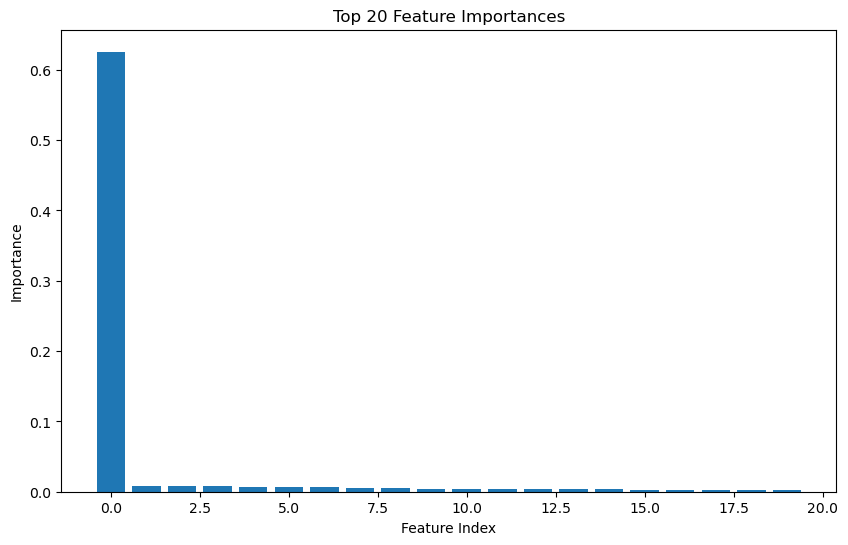

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.bar(range(20), feature_importances[indices[:20]])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances")
plt.show()

### (b) Review Category Distribution

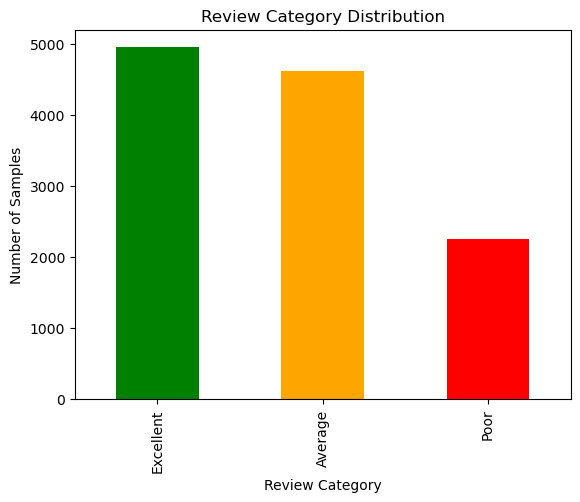

In [48]:
# Recalculate the distribution of the target variable
review_category_distribution = medicine_data['Review_Category'].value_counts()

# Plot the distribution
import matplotlib.pyplot as plt

review_category_distribution.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Review Category Distribution")
plt.xlabel("Review Category")
plt.ylabel("Number of Samples")
plt.show()

# Step 7: Deployment
We'll build a simple user interface to predict review categories based on user input.

### (a) Save Model and Transformers

In [49]:
import joblib

# Save model and transformers
joblib.dump(model, 'medicine_review_model.pkl')
joblib.dump(tfidf_uses, 'tfidf_uses_vectorizer.pkl')
joblib.dump(tfidf_side_effects, 'tfidf_side_effects_vectorizer.pkl')
joblib.dump(label_encoder, 'manufacturer_label_encoder.pkl')
print("Model and transformers saved successfully!")

Model and transformers saved successfully!


### (b) Install Required Libraries
Ensure the required libraries are installed in your environment:

In [40]:
!pip install flask joblib scipy

Defaulting to user installation because normal site-packages is not writeable


### (c) Create the Flask Application
#### Below is a complete Flask application script.


##### Flask_App.py
from flask import Flask, request, jsonify

import joblib

import scipy.sparse as sp

'''Load the saved components'''

model = joblib.load('medicine_review_model.pkl')

tfidf_uses = joblib.load('tfidf_uses_vectorizer.pkl')

tfidf_side_effects = joblib.load('tfidf_side_effects_vectorizer.pkl')

label_encoder = joblib.load('manufacturer_label_encoder.pkl')

'''Check if the components are loaded correctly'''

print(f"Model: {type(model)}")

print(f"TF-IDF Uses: {type(tfidf_uses)}")

print(f"TF-IDF Side Effects: {type(tfidf_side_effects)}")

print(f"Label Encoder: {type(label_encoder)}")

'''Initialize Flask app'''

app = Flask(__name__)

@app.route('/predict', methods=['POST'])

def predict():
    
    print("Predict endpoint hit!")  # Check if the endpoint is reached
    
    try:
        
        # Step 1: Get data from the request
        
        data = request.json
        
        print(f"Data received: {data}")  # Check the data received from the user
        
        if not data:
            
            print("No data provided")  # If no data is sent, return an error
            
            return jsonify({"error": "No data provided"}), 400

        # Step 2: Extract values from the input
        
        uses = data.get("Uses", "")
        
        side_effects = data.get("Side_effects", "")
        
        manufacturer = data.get("Manufacturer", "")
        
        print(f"Inputs - Uses: {uses}, Side Effects: {side_effects}, Manufacturer: {manufacturer}")
        
        # Step 3: Transform inputs using the saved transformers
        
        X_uses = tfidf_uses.transform([uses])
        
        print("Uses transformed")
        
        X_side_effects = tfidf_side_effects.transform([side_effects])
        
        print("Side Effects transformed")
        
        manufacturer_encoded = label_encoder.transform([manufacturer])
        
        print(f"Manufacturer encoded: {manufacturer_encoded}")

        # Step 4: Combine the features into a single matrix
        
        X_combined = sp.hstack([X_uses, X_side_effects, sp.csr_matrix(manufacturer_encoded).T])
        
        # Step 5: Make the prediction using the loaded model
        
        prediction = model.predict(X_combined)
        
        print(f"Prediction: {prediction}")  # Print prediction result

        # Step 6: Return the prediction as a response
        
        return jsonify({"Review_Category": prediction[0]})
    
    except Exception as e:
        
        print(f"Error occurred: {e}")  # Log the error if something goes wrong
        
        return jsonify({"error": "An error occurred."}), 500

if __name__ == '__main__':
    
    app.run(debug=True)

### (d) Run the Flask App
Run the Flask app using the command:

python app.py

The app will start at http://127.0.0.1:5000.

### (e) Test the APP
Test the APP using curl or Postman.

Example Request:

curl -X POST -H "Content-Type: application/json" -d '{
    "Uses": "Treatment of Bacterial infections",
    "Side_effects": "Vomiting Nausea Diarrhea Mucocutaneous candidiasis",
    "Manufacturer": "Glaxo SmithKline Pharmaceuticals Ltd"}' http://127.0.0.1:5000/predict


Expected Response:

{"Review_Category": "Excellent"}

Intead of using this download Postman and setup that and run through the Postman it works fine with Postman 

Steps to Use Postman:
 
 Download and install Postman.
     Linux : sudo apt install postman

Open Postman and set up the request:
    Set the Request Method to POST.
    Set the URL to http://127.0.0.1:5000/predict.
    Under the Headers tab, add:
        Key: Content-Type, Value: application/json
    Under the Body tab, select raw and then choose JSON format.
    
Enter your input data as JSON:

{
    "Uses": "Pain relief",
    "Side_effects": "Drowsiness",
    "Manufacturer": "Pfizer"
}

Click the Send button and you should see the response from your Flask app in the lower section of Postman.

## APP deployment
To deploy the app:

Heroku: Use Heroku CLI to deploy the app. Make sure to include a requirements.txt and Procfile.

AWS/Google Cloud: Package the app into a Docker container for deployment.

Local Access: Access the app on your local network using a tool like ngrok.